# <p style="text-align: center;"> Exploratory data analysis of online rating: The impact of the varience_ V3
    
## <p style="text-align: center;"> Supervisor: Proffessor Xiao Huang </p>
## <p style="text-align: center;"> Author: Amirhossein Hajigholam Saryazdi </p>
## <p style="text-align: center;"> July. 2022 </p>

## Introduction:


Have you ever get confused during your online shopping after seeing inconsistent reviews for a product and then hesitate to order? 

You are not alone in this feeling as researchers found high variance backfires on the review system and reduces the informativeness of online ratings. Through exploring online review data from Amazon, I discuss why trusting on the average rating can be misleading, doubt the bielef that online rating is a good proxy of quality, and show higher variance reduces the sale. *


*For this practice, Patio_Lawn_and_Garden category used from the following source:
https://nijianmo.github.io/amazon/index.html
http://jmcauley.ucsd.edu/data/amazon/links.html
<br>

In [1]:
# Importing required libraries

# Dataframe
import pandas as pd

# Array
import numpy as np

import json
import matplotlib.pyplot as plt
from matplotlib import colors

from mpl_toolkits import mplot3d
import plotly.express as px
import seaborn as sns
import math
import warnings
import statsmodels.api as sm
from statsmodels.api import OLS
import statsmodels.formula.api as smf
from patsy import dmatrices
from yellowbrick.cluster import KElbowVisualizer
import sklearn
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
sns.set_style("whitegrid")
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
df = pd.read_csv('Patio_Lawn_and_Garden_18_14.csv')

# fixing 'reviewTime' format
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

# Drop the first column
df.drop(columns=df.columns[0], axis=1, inplace=True)

df.head()

,asin,overall,reviewTime,reviewerID,also_buy,also_view,price2018,rank2018,price2014,rank2014
0,6035000029,3.0,2014-07-30,A36E5ZL6C4SRYT,[],"['B00KWRLZBO', 'B00JK3D26W', 'B06W9M14DR', 'B0...",7.51,297270.0,119.79,"{'Patio, Lawn & Garden': 41297}"
1,6035000029,4.0,2014-07-21,A3OAMQRSE8Z1KO,[],"['B00KWRLZBO', 'B00JK3D26W', 'B06W9M14DR', 'B0...",7.51,297270.0,119.79,"{'Patio, Lawn & Garden': 41297}"
2,6035000029,5.0,2014-07-10,A1HQCJTZPIUH0T,[],"['B00KWRLZBO', 'B00JK3D26W', 'B06W9M14DR', 'B0...",7.51,297270.0,119.79,"{'Patio, Lawn & Garden': 41297}"
3,6035000029,3.0,2014-05-01,A2JLMRP20CVAF2,[],"['B00KWRLZBO', 'B00JK3D26W', 'B06W9M14DR', 'B0...",7.51,297270.0,119.79,"{'Patio, Lawn & Garden': 41297}"
4,6035000029,5.0,2014-03-10,A3D6HSJ0592MBC,[],"['B00KWRLZBO', 'B00JK3D26W', 'B06W9M14DR', 'B0...",7.51,297270.0,119.79,"{'Patio, Lawn & Garden': 41297}"


In [3]:
print('The shape of the whole data:',df.shape)
print('The Number of the unique products is:',df['asin'].nunique())
print('The number of the unique reviewrs is:', df['reviewerID'].nunique())

The shape of the whole data: (1823410, 10)
The Number of the unique products is: 27691
The number of the unique reviewrs is: 1179113


## 1. Descriptive statistics: Why average is not a perfect measure in assessing the ratings? 

Looking at the summary of statistics from the data, it is surprisng that although the minimum overall rating is 1, the median, and third quartile are the same as the maximum, 5. Even the first quartile is very close to them. 

Looking at Figure 1, the distribution of all 1755812 ratings, contrary to the common bielef of normal distribution for large numbers, they seem to have a so called J-shaped distribution. It displays consumers tends to submit more extreme reviews with a much greater emphasis on the positive side. A due question to ask are What is the reason behind this and what are the consequences?

Considering this asymmetric distribution, arithmetic mean of ratings seems not to be a good estimator of ratings anymore *(Hu et al. 2009)*.

**Underlying reasons of abundant positive reviews *(Zervas et al. 2021)*** : 

- Herding
- Underreporting of negative: happens in two-sided review systems when reviewers are scared of retaliatory negative reviews
- Self-selection bias
- Manipulation 
- Attrition *(Brandes et al. 2022)*

In [4]:
df.describe()

,overall,price2018,rank2018,price2014
count,1.823410e+06,1.823410e+06,1.816536e+06,1.823410e+06
mean,4.130330e+00,3.207954e+01,7.404273e+04,5.189984e+01
std,1.362570e+00,5.540225e+01,4.190487e+05,8.233043e+01
min,1.000000e+00,1.000000e-02,2.000000e+00,1.000000e-02
25%,4.000000e+00,8.400000e+00,3.765000e+03,1.145000e+01
50%,5.000000e+00,1.587000e+01,1.681500e+04,2.415000e+01
75%,5.000000e+00,3.300000e+01,6.843000e+04,5.295000e+01
max,5.000000e+00,1.350000e+03,1.275723e+07,9.999900e+02


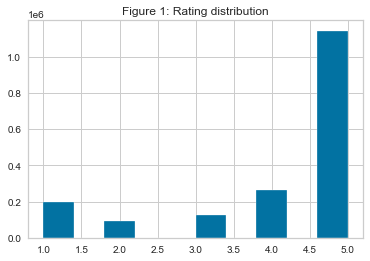

In [5]:
df.overall.hist()
plt.title("Figure 1: Rating distribution")
plt.show()

## 2. Exploring unique asin: How considering average ratings as a proxy for quality can be misleading:

Now it is time to decompose product ratings into their three dimensions of valence, voume, and varience.

Looking at the histogram of the valence (average) of rating for each product, figure 2, we see that they are overwhelmingly positive. Does it mean that the majority of products in this category are of a high quality or the it is positively skewd *(Chen et al. 2021)* ?

Speaking of the volume ,figure 3 and 4, of the volume and variance of ratings, the majority of products, 75%, has less than 43 ratings and 2.4 variance.

In [10]:
df2=df[['asin','overall','reviewerID', 'price2018', 'rank2018', 'price2014']]

df2=df2.groupby('asin', as_index=False)['overall','price2018','rank2018', 'price2014'].mean()
df2=df2.rename(columns={'overall':'valence'})

df2_=df.groupby('asin', as_index=False).count()
df2['volume']=df2_['overall']

df2_=df.groupby('asin', as_index=False)['overall'].var()
df2['variance']=df2_['overall']

df2['variance'] = df2['variance'].replace(np.nan, 0)


df2

,asin,valence,price2018,rank2018,price2014,volume,variance
0,1554701503,4.333333,24.85,574599.0,26.39,3,1.333333
1,6035000029,2.960000,7.51,297270.0,119.79,25,2.790000
2,6035000045,3.333333,124.86,634104.0,138.29,3,4.333333
3,8805002577,3.500000,49.81,502862.0,54.99,2,4.500000
4,B0000001QY,4.740741,6.92,88625.0,12.55,27,0.276353
...,...,...,...,...,...,...,...
27686,B00L5J7S50,3.460208,13.89,54754.0,10.95,289,2.895112
27687,B00L748GFO,4.240000,12.99,265374.0,10.55,25,1.606667
27688,B00LA3Y82M,4.497797,17.32,46376.0,26.73,227,0.905969
27689,B00LDJAR8C,4.254545,9.91,80345.0,8.65,55,1.452525


In [11]:
df2.describe()

,valence,price2018,rank2018,price2014,volume,variance
count,27691.000000,27691.000000,2.757900e+04,27691.000000,27691.000000,27691.000000
mean,4.009309,38.029485,2.947885e+05,50.038723,65.848471,1.504249
std,0.889735,76.391809,5.009195e+05,96.552654,252.223866,1.393916
min,1.000000,0.010000,2.000000e+00,0.010000,1.000000,0.000000
25%,3.600000,7.880000,6.649300e+04,9.000000,4.000000,0.333333
50%,4.246753,16.390000,1.774550e+05,19.950000,12.000000,1.292105
75%,4.666667,35.670000,3.633455e+05,44.990000,43.000000,2.328376
max,5.000000,1350.000000,1.275723e+07,999.990000,16332.000000,8.000000


We have an significant standard deviation in price and volume columns and a vast difference between the 75th percentile value and the maximum value there. This indicates that we might have some noise in our dataset, and it might be necessary to get rid of the noisy data points before we continue with our analysis. Therefore, we only keep those data points in our data frame within the 95th percentile range. We also eliminates prices which are less than 1$.

In [12]:
df3=df2.copy()
df3.drop(df3[df3.price2018 < 1].index, axis=0, inplace=True)
df3.drop(df3[df3.price2014 < 1].index, axis=0, inplace=True)

# cleaning outliers of price2018
ninety_quantile = df3["price2018"].quantile(0.95)
df3 = df3[df3["price2018"] <= ninety_quantile]

# cleaning outliers of price2014
ninety_quantile = df3["price2014"].quantile(0.95)
df3 = df3[df3["price2014"] <= ninety_quantile]

# cleaning outliers of volume
ninety_quantile = df3["volume"].quantile(0.95)
df3 = df3[df3["volume"] <= ninety_quantile]

df3.reset_index(drop=True, inplace=True)

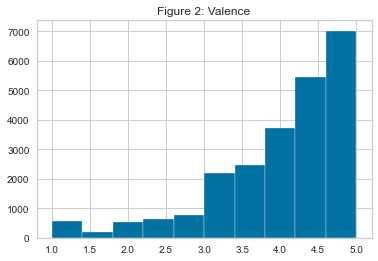

In [13]:
df3.valence.hist()
plt.title("Figure 2: Valence")
plt.show()

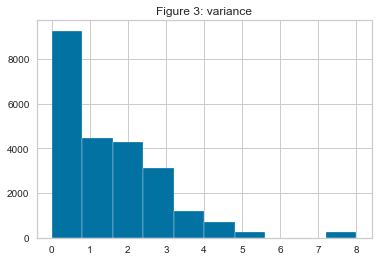

In [35]:
df3.variance.hist()
plt.title("Figure 3: variance")
plt.show()

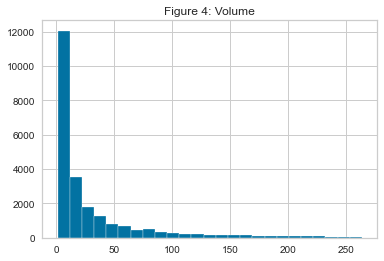

In [15]:
plt.hist(df3['volume'], bins=25)
plt.title("Figure 4: Volume")
plt.show()

### 2.1 Why average products have more variance in their ratings?

Figure 5 shows another interesting pattern. As the valence of the ratings of a product go towards to be very good or very bad, the variance of rating for that product decreases. The majority of high varience products have a valence around 3. The question here to ask is why extreme valences have less variance?

Figure 6 shed light on this shape and displays when volume increases, valence tends to be higher, but variance becomes lower.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


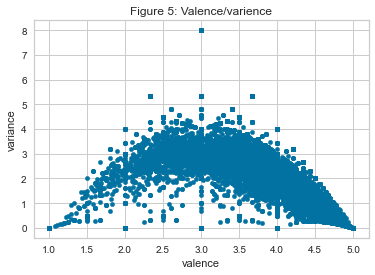

In [16]:
df3.plot(x='valence',y='variance',kind = 'scatter')
plt.title("Figure 5: Valence/varience")
plt.show()

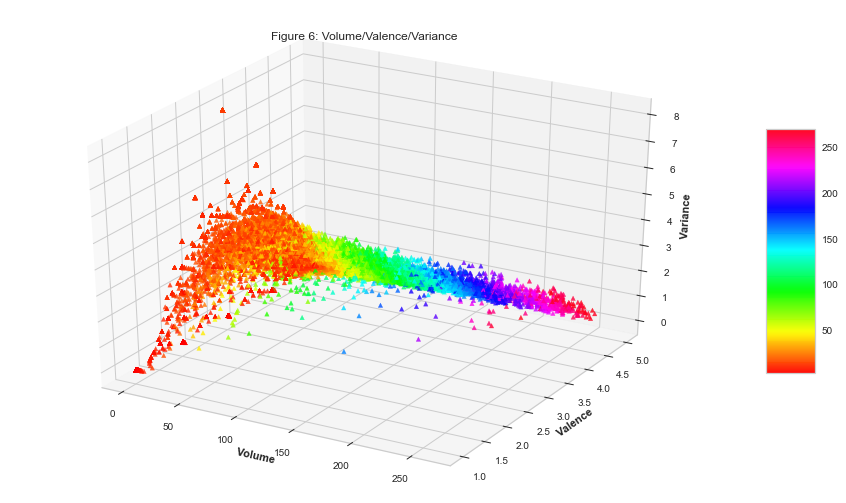

In [17]:
x=df3['volume']
y=df3['valence']
z=df3['variance']

# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = (x + y + z),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("Figure 6: Volume/Valence/Variance")
ax.set_xlabel('Volume', fontweight ='bold')
ax.set_ylabel('Valence', fontweight ='bold')
ax.set_zlabel('Variance', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

## 2.2 Clustering based on the ratings dimensions

The optimal numbers of clusters is 4. As seen in the figure 7 and 8, The largest cluster by far is the group of products with the lowest volume of ratings and wider range of valence.

Looking at the distributin of the clusters as per price features, figure 9 and 10, there is not a significant difference among them.

In [18]:
selected_cols = ["valence","variance","volume"]

cluster_data = df3.loc[:,selected_cols]

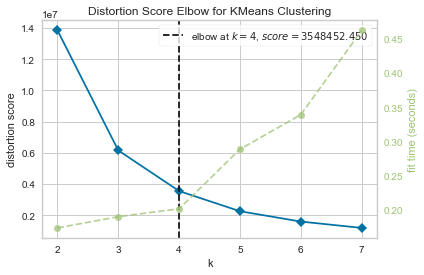

In [19]:
from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(), k=7)
Elbow_M.fit(cluster_data)
Elbow_M.show()

In [20]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(cluster_data)
cluster_data["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
df3["Clusters"]= yhat_AC

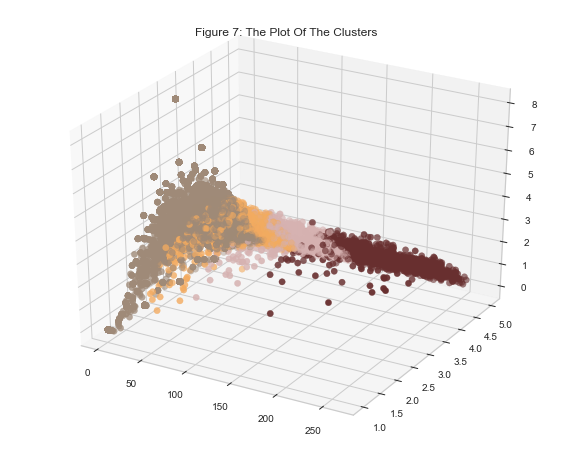

In [21]:
#Plotting the clusters
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=cluster_data["Clusters"], marker='o', cmap = cmap )
ax.set_title("Figure 7: The Plot Of The Clusters")
plt.show()

As it is shown in the figure 7, The products are clustered based on the volume of ratings.

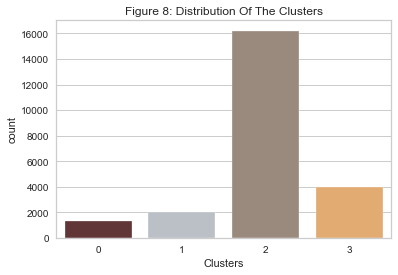

In [22]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df3["Clusters"], palette= pal)
pl.set_title("Figure 8: Distribution Of The Clusters")
plt.show()

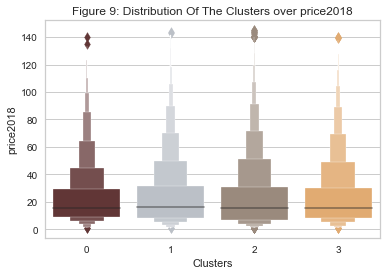

In [33]:
plt.figure()
pl=sns.boxenplot(x=df3["Clusters"], y=df3["price2018"], palette=pal)
pl.set_title("Figure 9: Distribution Of The Clusters over price2018")

plt.show()

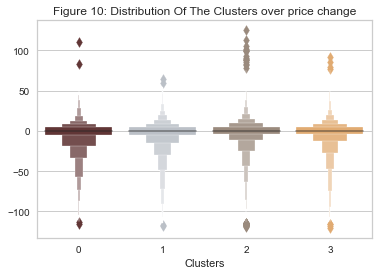

In [19]:
plt.figure()
y=df3['price2018']-df3['price2014']

pl=sns.boxenplot(x=df3["Clusters"], y=y, palette=pal)
pl.set_title("Figure 10: Distribution Of The Clusters over price change")

plt.show()

## 2.3 Looking within the clusters:

**Cluster 0 & 1** has the highest amount of ratings, but the lowest number of proucts, respectively. In fact, they account for **15%** of all the products, together. The distribution of **(*valence, variance, volume, and price2018*)** are almost the same in two clusters.

**Cluster 2**, on the other hand, make up for near **70%** of all the products, while it has the lowest volume of ratings. Interestingly, it encompas a wider range of **valence** and **variance** compared to other clusters and the distribution of these two attributes is a bit different here: the majority of products in this cluster have the maximum **valence** and the minimum **variance** Figure 17 to 19. 

**cluster 3** has the second smallest volume, but the second largest ration of the whole products with around **15%**.

Surprisingly, all clusters have almost the same price distribution and range.

In [23]:
df3_0 = df3[df3['Clusters'] == 0]
df3_1 = df3[df3['Clusters'] == 1]
df3_2 = df3[df3['Clusters'] == 2]
df3_3 = df3[df3['Clusters'] == 3]

In [24]:
df3_0.describe()

,valence,price2018,rank2018,price2014,volume,variance,Clusters
count,1302.000000,1302.000000,1295.000000,1302.000000,1302.000000,1302.000000,1302.0
mean,4.153302,23.101359,49739.488803,26.963779,185.870200,1.551086,0.0
std,0.519141,22.132805,65704.793837,24.239918,37.328702,0.744754,0.0
min,1.651899,1.180000,9.000000,1.240000,133.000000,0.148201,0.0
25%,3.878932,8.885000,9686.000000,9.990000,153.000000,0.947020,0.0
50%,4.293675,15.550000,28115.000000,18.955000,179.000000,1.472013,0.0
75%,4.540624,29.000000,70579.000000,34.192500,216.000000,2.106213,0.0
max,4.900000,140.000000,820447.000000,125.000000,264.000000,3.487738,0.0


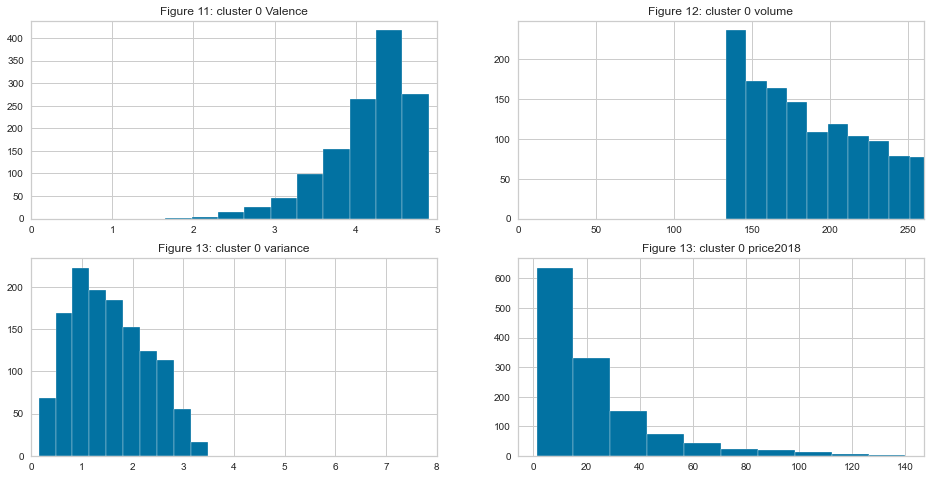

In [27]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
df3_0.valence.hist()
plt.xlim(xmin=0, xmax=5)
plt.title("Figure 11: cluster 0 Valence")

plt.subplot(2,2,2)
df3_0.volume.hist()
plt.xlim(xmin=0, xmax=260)
plt.title("Figure 12: cluster 0 volume")

plt.subplot(2,2,3)
df3_0.variance.hist()
plt.xlim(xmin=0, xmax=8)
plt.title("Figure 13: cluster 0 variance")

plt.subplot(2,2,4)
df3_0.price2018.hist()
#plt.xlim(xmin=0, xmax=8)
plt.title("Figure 13: cluster 0 price2018")

plt.show()

In [59]:
df3_1.describe()

,valence,price2018,rank2018,price2014,volume,variance,Clusters
count,2004.000000,2004.000000,1.994000e+03,2004.000000,2004.000000,2004.000000,2004.0
mean,4.142315,24.362959,7.016801e+04,27.229406,93.433633,1.556650,1.0
std,0.560348,24.030841,8.209738e+04,25.414188,18.547912,0.804755,0.0
min,1.569620,1.010000,3.000000e+01,1.000000,66.000000,0.040493,1.0
25%,3.835604,8.392500,1.788875e+04,9.950000,78.000000,0.895506,1.0
50%,4.294118,15.990000,4.839700e+04,18.500000,90.000000,1.470351,1.0
75%,4.561368,31.275000,1.006792e+05,34.990000,108.000000,2.212153,1.0
max,4.974026,143.950000,1.169539e+06,124.990000,132.000000,3.688380,1.0


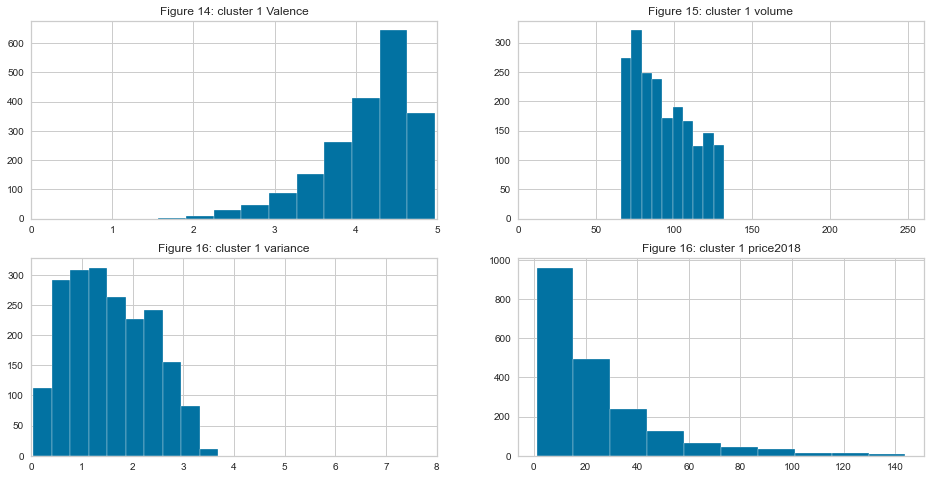

In [29]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
df3_1.valence.hist()
plt.xlim(xmin=0, xmax=5)
plt.title("Figure 14: cluster 1 Valence")

plt.subplot(2,2,2)
df3_1.volume.hist()
plt.xlim(xmin=0, xmax=260)
plt.title("Figure 15: cluster 1 volume")

plt.subplot(2,2,3)
df3_1.variance.hist()
plt.xlim(xmin=0, xmax=8)
plt.title("Figure 16: cluster 1 variance")

plt.subplot(2,2,4)
df3_1.price2018.hist()
#plt.xlim(xmin=0, xmax=8)
plt.title("Figure 16: cluster 1 price2018")

plt.show()

In [60]:
df3_2.describe()

,valence,price2018,rank2018,price2014,volume,variance,Clusters
count,16213.000000,16213.000000,1.614900e+04,16213.000000,16213.000000,16213.000000,16213.0
mean,3.950483,23.912195,3.890652e+05,25.459991,7.810831,1.468539,2.0
std,1.011854,24.817024,5.431086e+05,25.136988,6.549056,1.616607,0.0
min,1.000000,1.000000,3.000000e+00,1.000000,1.000000,0.000000,2.0
25%,3.421053,6.950000,1.486190e+05,7.760000,2.000000,0.000000,2.0
50%,4.200000,15.180000,2.714450e+05,16.990000,6.000000,1.000000,2.0
75%,4.750000,30.990000,4.670740e+05,33.950000,12.000000,2.444444,2.0
max,5.000000,144.990000,1.245872e+07,125.580000,26.000000,8.000000,2.0


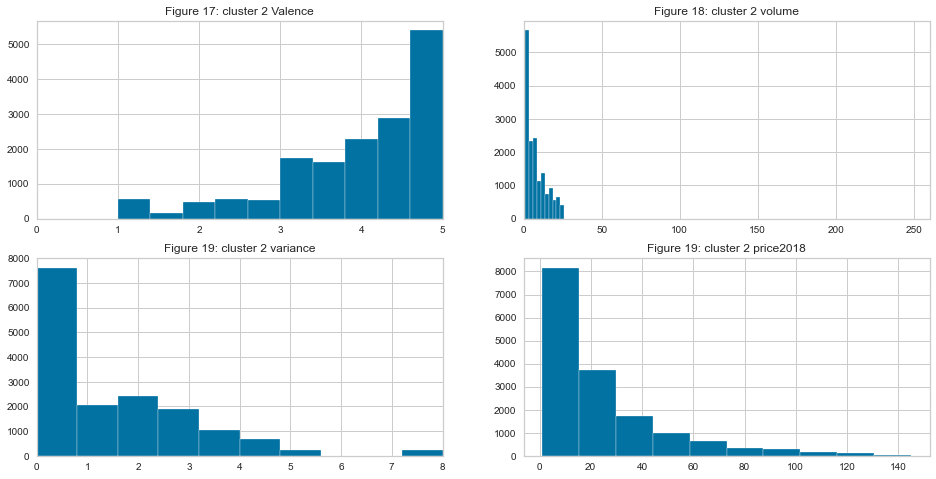

In [30]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
df3_2.valence.hist()
plt.xlim(xmin=0, xmax=5)
plt.title("Figure 17: cluster 2 Valence")

plt.subplot(2,2,2)
df3_2.volume.hist()
plt.xlim(xmin=0, xmax=260)
plt.title("Figure 18: cluster 2 volume")

plt.subplot(2,2,3)
df3_2.variance.hist()
plt.xlim(xmin=0, xmax=8)
plt.title("Figure 19: cluster 2 variance")

plt.subplot(2,2,4)
df3_2.price2018.hist()
#plt.xlim(xmin=0, xmax=8)
plt.title("Figure 19: cluster 2 price2018")

plt.show()

In [61]:
df3_3.describe()

,valence,price2018,rank2018,price2014,volume,variance,Clusters
count,4010.000000,4010.000000,3.996000e+03,4010.000000,4010.000000,4010.000000,4010.0
mean,4.139782,23.563668,1.167432e+05,26.070943,41.648379,1.538718,3.0
std,0.608273,23.567438,1.217617e+05,24.724550,11.644054,0.872535,0.0
min,1.380952,1.120000,3.600000e+01,1.000000,26.000000,0.000000,3.0
25%,3.851261,7.930000,4.168275e+04,9.272500,31.250000,0.820547,3.0
50%,4.315302,15.610000,9.377750e+04,17.760000,40.000000,1.442759,3.0
75%,4.583333,29.950000,1.593715e+05,33.585000,51.000000,2.199321,3.0
max,5.000000,140.110000,2.340299e+06,125.000000,67.000000,3.751724,3.0


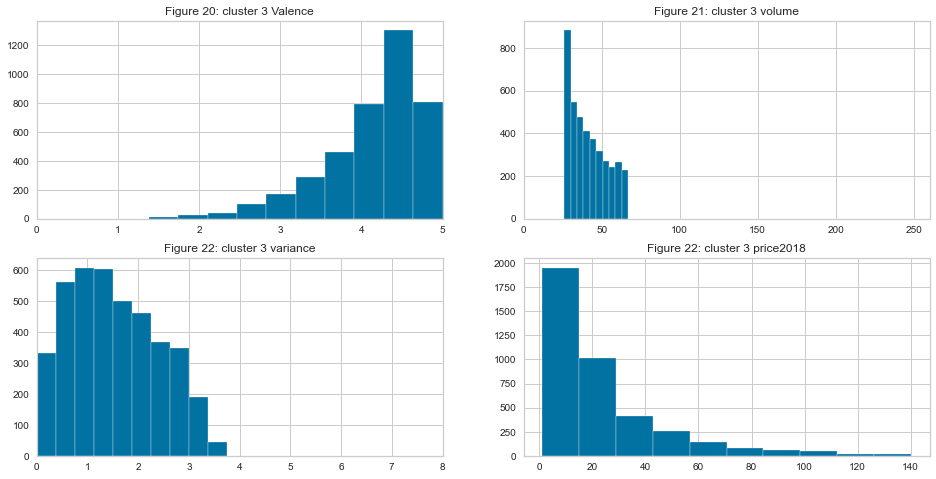

In [31]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
df3_3.valence.hist()
plt.xlim(xmin=0, xmax=5)
plt.title("Figure 20: cluster 3 Valence")

plt.subplot(2,2,2)
df3_3.volume.hist()
plt.xlim(xmin=0, xmax=260)
plt.title("Figure 21: cluster 3 volume")

plt.subplot(2,2,3)
df3_3.variance.hist()
plt.xlim(xmin=0, xmax=8)
plt.title("Figure 22: cluster 3 variance")

plt.subplot(2,2,4)
df3_3.price2018.hist()
#plt.xlim(xmin=0, xmax=8)
plt.title("Figure 22: cluster 3 price2018")

plt.show()

## 2.3 Are expensive items popular?

Figure 11 shows that there are less ratings as the price goes up. It may indicates that consumer are less interested in expensive products.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


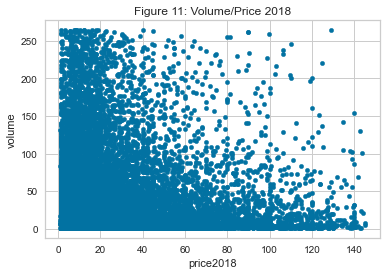

In [114]:
df3.plot(x='price2018',y='volume',kind = 'scatter')
plt.title("Figure 11: Volume/Price 2018")
plt.show()

### 2.3 When there are stablished consumers, it may not wise to make a big change in price

Figure 12 shows that products with higher volume of ratings, also experinced much less price change. 

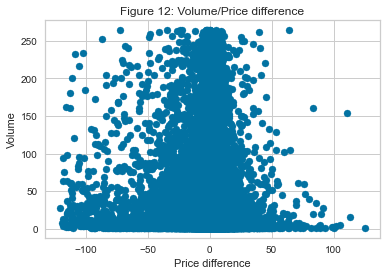

In [115]:
x=df3['price2018']-df3['price2014']
y=df3['volume']

plt.scatter(x,y)
plt.xlabel("Price difference")
plt.ylabel("Volume")
plt.title("Figure 12: Volume and Price difference")

plt.show()

## 3. Does variance harm the sale?

Is the impact of variance on sale is meaningful or negligible? Does it act in favour or against it?

The following table indicates the negative effect of variance on sales and it is statistically meaningful (it increases sales rank). While this regression and specification is a cartoon of a solid econometrics analysis, it helps to give the reader an idea of how different dimensions of ratings can have a causal effect on sales.

In [12]:
df2['lnrank2018'] = np.log(df2['rank2018'])
df2['lnprice2018'] = np.log(df2['price2018'])
df2['lnvalence'] = np.log(df2['valence'])
df2['lnvolume'] = np.log(df2['volume'])


y, X = dmatrices('lnrank2018 ~ lnprice2018 + lnvalence + lnvolume + variance', data=df2, return_type='dataframe')

mod = sm.OLS(y, X)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             lnrank2018   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     6414.
Date:                Tue, 19 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:15:37   Log-Likelihood:                -36233.
No. Observations:               25118   AIC:                         7.248e+04
Df Residuals:                   25113   BIC:                         7.252e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      14.1769      0.048    295.652      

## 4. Is there any trend between the two period? (2014 vs 2018)

In this section, I tried to compare 2014 and 2018 ratings and see if there is any relationship between the change in the dimension of ratings before and after 2014, figure 14. I also tired to see if there is any relationship between price changes and change in those ratings dimensions, figure 13. In either case, I could not find any interesting trend.

In [107]:
# Grouping ratings based on before and after 2014
df2014=df[df['reviewTime'] <= '2014-12-31']
df2018=df[df['reviewTime'] > '2014-12-31']

In [108]:
df14=df2014[['asin','overall','reviewerID', 'rank2014', 'price2014']]

df14=df14.groupby('asin', as_index=False)['overall','rank2014','price2014'].mean()
df14=df14.rename(columns={'overall':'valence2014'})

df14_=df2014.groupby('asin', as_index=False).count()
df14['volume2014']=df14_['overall']

df14_=df2014.groupby('asin', as_index=False)['overall'].var()
df14['variance2014']=df14_['overall']

df14.describe()

,valence2014,price2014,volume2014,variance2014
count,27600.000000,27600.000000,27600.000000,21383.000000
mean,4.035638,50.073802,22.125652,1.546607
std,1.010516,96.559661,97.010182,1.592641
min,1.000000,0.010000,1.000000,0.000000
25%,3.571429,9.000000,2.000000,0.295833
50%,4.330086,19.950000,4.000000,1.165591
75%,4.895011,44.990000,13.000000,2.333333
max,5.000000,999.990000,6038.000000,8.000000


In [109]:
df14.drop(df14[df14.price2014 < 1].index, axis=0, inplace=True)

# cleaning outliers of price2014
ninety_quantile = df14["price2014"].quantile(0.95)
df14 = df14[df14["price2014"] <= ninety_quantile]

# cleaning outliers of volume
ninety_quantile = df14["volume2014"].quantile(0.95)
df14 = df14[df14["volume2014"] <= ninety_quantile]

In [110]:
df18=df2018[['asin','overall','reviewerID', 'rank2018', 'price2018']]

df18=df18.groupby('asin', as_index=False)['overall','rank2018','price2018'].mean()
df18=df18.rename(columns={'overall':'valence2018'})

df18_=df2018.groupby('asin', as_index=False).count()
df18['volume2018']=df18_['overall']

df18_=df2018.groupby('asin', as_index=False)['overall'].var()
df18['variance2018']=df18_['overall']

df18.describe()

,valence2018,rank2018,price2018,volume2018,variance2018
count,23577.000000,2.348800e+04,23577.000000,23577.000000,20821.000000
mean,4.046426,2.069318e+05,36.279740,51.437503,1.635213
std,0.926962,2.803107e+05,71.600939,185.672912,1.420792
min,1.000000,2.000000e+00,0.010000,1.000000,0.000000
25%,3.666667,5.383775e+04,7.880000,3.000000,0.500000
50%,4.307692,1.456405e+05,16.100000,10.000000,1.412088
75%,4.714286,2.757248e+05,34.940000,35.000000,2.447477
max,5.000000,9.670998e+06,1350.000000,10294.000000,8.000000


In [111]:
df18.drop(df18[df18.price2018 < 1].index, axis=0, inplace=True)

# cleaning outliers of price2014
ninety_quantile = df18["price2018"].quantile(0.95)
df18 = df18[df18["price2018"] <= ninety_quantile]

# cleaning outliers of volume
ninety_quantile = df18["volume2018"].quantile(0.95)
df18 = df18[df18["volume2018"] <= ninety_quantile]

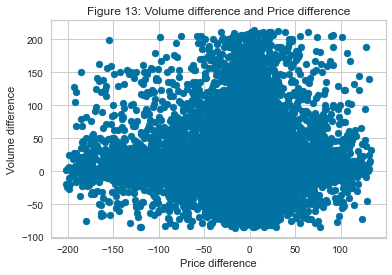

In [118]:
x=df18['price2018']-df14['price2014']
y=df18['volume2018']-df14['volume2014']

plt.scatter(x,y)
plt.title("Figure 13: Volume difference and Price difference")

plt.xlabel("Price difference")
plt.ylabel("Volume difference")
plt.show()

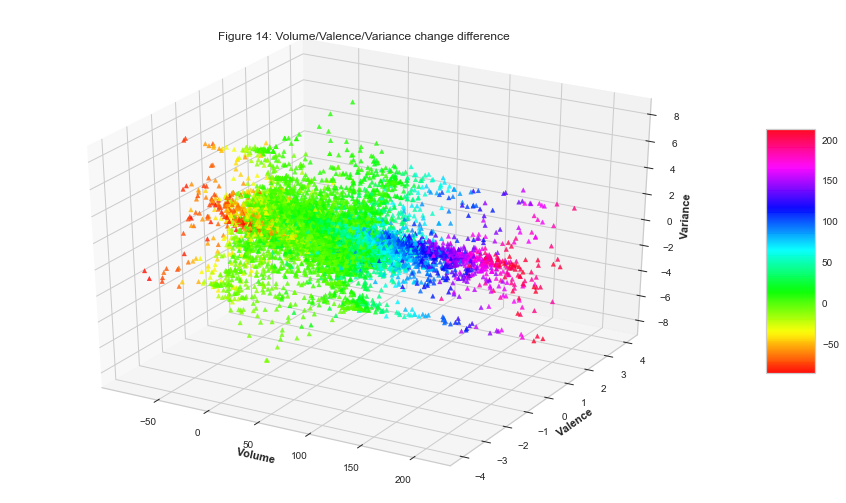

In [117]:
x=df18['volume2018']-df14['volume2014']
y=df18['valence2018']-df14['valence2014']
z=df18['variance2018']-df14['variance2014']

# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = (x + y + z),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("Figure 14: Volume/Valence/Variance change difference")
ax.set_xlabel('Volume', fontweight ='bold')
ax.set_ylabel('Valence', fontweight ='bold')
ax.set_zlabel('Variance', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

## 5. Exploring unique reviewerID

In [34]:
df4=df[['reviewerID','overall', 'price2018', 'rank2018', 'price2014']]

df4=df4.groupby('reviewerID', as_index=False)['overall','price2018','rank2018', 'price2014'].mean()
df4=df4.rename(columns={'overall':'valence'})

df4_=df.groupby('reviewerID', as_index=False).count()
df4['volume']=df4_['overall']

df4_=df.groupby('reviewerID', as_index=False)['overall'].var()
df4['variance']=df4_['overall']

df4['variance'] = df4['variance'].replace(np.nan, 0)


df4

,reviewerID,valence,price2018,rank2018,price2014,volume,variance
0,A0001528BGUBOEVR6T5U,3.60,6.444,106184.00,40.222,5,3.80
1,A0004644E5K099G49XX3,5.00,2.770,1739.00,3.810,1,0.00
2,A0008742LGM0SWUBVLZY,1.00,32.500,137450.00,27.930,1,0.00
3,A0009478CBXKUCALUC7U,4.25,36.605,4275.25,55.860,4,0.25
4,A00192248SWZLIGVDBH1,5.00,50.340,18417.00,39.960,1,0.00
...,...,...,...,...,...,...,...
1179108,AZZZ871Y5ZC4F,5.00,24.650,303122.00,21.640,1,0.00
1179109,AZZZBHHLU1CMM,5.00,16.230,75607.00,15.260,1,0.00
1179110,AZZZFM3S6FSAQ,5.00,148.990,22186.00,10.990,1,0.00
1179111,AZZZTBC2IU0NK,5.00,4.920,164269.00,147.210,1,0.00


In [38]:
df4.describe()

,valence,price2018,rank2018,price2014,volume,variance
count,1.179113e+06,1.179113e+06,1.175509e+06,1.179113e+06,1.179113e+06,1.179113e+06
mean,4.075729e+00,3.378017e+01,8.074349e+04,5.693090e+01,1.546425e+00,2.123828e-01
std,1.361340e+00,5.656603e+01,4.487531e+05,8.495669e+01,1.323601e+00,9.491859e-01
min,1.000000e+00,1.000000e-02,2.000000e+00,1.000000e-02,1.000000e+00,0.000000e+00
25%,3.666667e+00,9.550000e+00,4.937000e+03,1.365000e+01,1.000000e+00,0.000000e+00
50%,5.000000e+00,1.734000e+01,2.106800e+04,2.699000e+01,1.000000e+00,0.000000e+00
75%,5.000000e+00,3.499000e+01,7.362500e+04,6.011500e+01,2.000000e+00,0.000000e+00
max,5.000000e+00,1.350000e+03,1.275723e+07,9.999900e+02,1.570000e+02,8.000000e+00


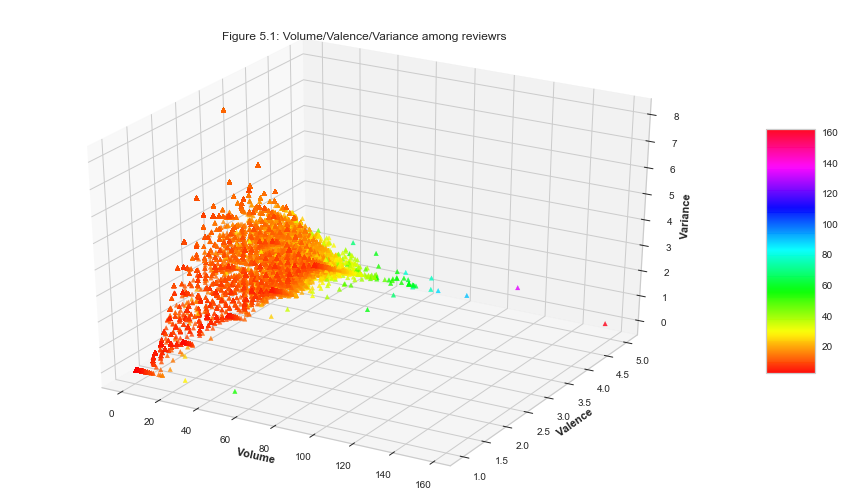

In [42]:
x=df4['volume']
y=df4['valence']
z=df4['variance']

# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = (x + y + z),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("Figure 5.1: Volume/Valence/Variance among reviewrs")
ax.set_xlabel('Volume', fontweight ='bold')
ax.set_ylabel('Valence', fontweight ='bold')
ax.set_zlabel('Variance', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()